In [2]:
# Streamlined imports - removing duplicates
import esm
import pandas as pd
import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR
from torch.nn.utils.rnn import pad_sequence
from torch.amp import autocast
from torch.cuda.amp import GradScaler

import sys
import os
import time
import math
import random
import pickle
import subprocess
import gc
from pathlib import Path
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import display, update_display

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ESM imports
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig, ESMProteinTensor
from esm.models.esmc import _BatchedESMProteinTensor

# Tokenizer imports
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers import normalizers
from tokenizers.normalizers import NFD, Lowercase, StripAccents
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordPieceTrainer
from tokenizers import decoders

# PEFT imports
from peft import get_peft_model, LoraConfig, TaskType
from peft.tuners.lora import LoraConfig, LoraModel

# Set environment variable
os.environ["TOKENIZERS_PARALLELISM"] = "false"


/home/natasha/miniconda3/envs/tcr-multimodal/lib/python3.10/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


##### Investigation into Z

In [3]:
# get Boltz embeddings
file_path = '/home/natasha/multimodal_model/outputs/boltz_runs/positives/pair_000/boltz_results_pair_000/predictions/pair_000/embeddings_pair_000.npz'

In [4]:
# shape of s is the sum of the lengths of the TCR, HLA and peptide [batch, sum_of_len, dim (384)]
# shape of z is the length of the TCR, HLA and peptide twice [batch, sum_of_len, sum_of_len, dim (128)]

with np.load(file_path) as data:
    print(list(data.keys()))
    print(data['s'].shape)
    print(data['z'].shape)
    s = data['s']
    z = data['z']
    Z = torch.tensor(z)

   
    

['s', 'z']
(1, 604, 384)
(1, 604, 604, 128)


In [5]:
# feat1 = Z[:, :, 0]

# feat1_T = feat1.T

# is_sym = np.allclose(feat1, feat1_T, atol=1e-8)
# asym_max = np.max(np.abs(feat1-feat1_T))

# print("Symmetric:", is_sym, "| max |Z - Zᵀ|:", asym_max)
# print(feat1.max(), feat1.min())
# # check symmetry with respect to each dimension



In [9]:
L_p = 10
L_alpha = 112
L_beta = 117
L_hla = 365

s_alpha = slice(0, L_alpha)
s_beta = slice(L_alpha, L_alpha + L_beta)
s_pep = slice(L_alpha + L_beta, L_alpha + L_beta + L_p)
s_hla = slice(L_alpha + L_beta + L_p, L_alpha + L_beta + L_p + L_hla)

# --- 1) Extract diagonal (self-chain) blocks ---
A_aa = Z[:, s_alpha, s_alpha, :]
A_bb = Z[:, s_beta,  s_beta,  :]
A_pp = Z[:, s_pep,   s_pep,   :]
A_hh = Z[:, s_hla,   s_hla,   :]

# --- 2) Extract off-diagonal (cross-chain) blocks ---
C_ab = Z[:, s_alpha, s_beta,  :]       # (B, 112,117,D)
C_ba = Z[:, s_beta,  s_alpha, :]       # (B, 117,112,D)

C_ap = Z[:, s_alpha, s_pep,   :]       # (B, 112,10,D)
C_pa = Z[:, s_pep,   s_alpha, :]       # (B, 10,112,D)

C_ah = Z[:, s_alpha, s_hla,   :]       # (B, 112,365,D)
C_ha = Z[:, s_hla,   s_alpha, :]       # (B, 365,112,D)

C_bp = Z[:, s_beta,  s_pep,   :]       # (B, 117,10,D)
C_pb = Z[:, s_pep,   s_beta,  :]       # (B, 10,117,D)

C_bh = Z[:, s_beta,  s_hla,   :]       # (B, 117,365,D)
C_hb = Z[:, s_hla,   s_beta,  :]       # (B, 365,117,D)

C_ph = Z[:, s_pep,   s_hla,   :]       # (B, 10,365,D)
C_hp = Z[:, s_hla,   s_pep,   :]       # (B, 365,10,D)

# --- 3) Check symmetry of Z ---
skew_aa = (A_aa - A_aa.transpose(-2, -3)).abs().amax(dim=(-3,-2))
skew_bb = (A_bb - A_bb.transpose(-2, -3)).abs().amax(dim=(-3,-2))
skew_pp = (A_pp - A_pp.transpose(-2, -3)).abs().amax(dim=(-3,-2))
skew_hh = (A_hh - A_hh.transpose(-2, -3)).abs().amax(dim=(-3,-2))


diff_ab = (C_ab - C_ba.transpose(-2, -3)).abs()  # expect ~0
diff_ap = (C_ap - C_pa.transpose(-2, -3)).abs()
diff_ah = (C_ah - C_ha.transpose(-2, -3)).abs()
diff_bp = (C_bp - C_pb.transpose(-2, -3)).abs()
diff_bh = (C_bh - C_hb.transpose(-2, -3)).abs()
diff_ph = (C_ph - C_hp.transpose(-2, -3)).abs()

diff_ab = (C_ab - C_ba.transpose(-2, -3)).abs().amax(dim=(-3,-2)) # (B,D)
diff_ap = (C_ap - C_pa.transpose(-2, -3)).abs().amax(dim=(-3,-2))
diff_ah = (C_ah - C_ha.transpose(-2, -3)).abs().amax(dim=(-3,-2))
diff_bp = (C_bp - C_pb.transpose(-2, -3)).abs().amax(dim=(-3,-2))
diff_bh = (C_bh - C_hb.transpose(-2, -3)).abs().amax(dim=(-3,-2))
diff_ph = (C_ph - C_hp.transpose(-2, -3)).abs().amax(dim=(-3,-2))

print("Max per-channel diff (alpha-beta):", diff_ab.amax(dim=0))
print("Max per-channel diff (alpha-pep) :", diff_ap.amax(dim=0))
print("Max per-channel diff (alpha-hla) :", diff_ah.amax(dim=0))
print("Max per-channel diff (beta-pep) :", diff_bp.amax(dim=0))
print("Max per-channel diff (beta-hla) :", diff_bh.amax(dim=0))
print("Max per-channel diff (pep-hla) :", diff_ph.amax(dim=0))

stats = {
    "alpha-beta": diff_ab,
    "alpha-pep": diff_ap,
    "alpha-hla": diff_ah,
    "beta-pep": diff_bp,
    "beta-hla": diff_bh,
    "pep-hla": diff_ph,
}

for name, diff in stats.items():
    mean_per_channel = diff.mean(dim=0)
    std_per_channel = diff.std(dim=0, unbiased=False)
    print(f"Mean abs diff per channel ({name}):", mean_per_channel)
    print(f"Std abs diff per channel ({name}):", std_per_channel)
    top_vals, top_idx = torch.topk(mean_per_channel, k=min(5, mean_per_channel.numel()))
    print(f"Top channels by mean abs diff ({name}): idx={top_idx.tolist()}, vals={top_vals.tolist()}")

# Optional: single example (batch 0) boolean pass/fail with tolerance
atol = 1e-6
print("b0 pass/fail (alpha-beta):", torch.all(diff_ab[0] <= atol).item())
print("b0 pass/fail (alpha-pep) :", torch.all(diff_ap[0] <= atol).item())
print("b0 pass/fail (alpha-hla) :", torch.all(diff_ah[0] <= atol).item())
print("b0 pass/fail (beta-pep) :", torch.all(diff_bp[0] <= atol).item())
print("b0 pass/fail (beta-hla) :", torch.all(diff_bh[0] <= atol).item())
print("b0 pass/fail (pep-hla) :", torch.all(diff_ph[0] <= atol).item())

# --- 6) (Optional) Enforce symmetry globally, then add identity on diagonal blocks ---

# Enforce symmetry of the full matrix per channel:
Z_sym = 0.5 * (Z + Z.transpose(-3, -2))

# Add +I to each diagonal block (alpha/beta/pep/hla) with weight=1.0
Z_star = Z_sym.clone()

I_aa = torch.eye(112, device=Z.device, dtype=Z.dtype).view(1,112,112,1)
I_bb = torch.eye(117, device=Z.device, dtype=Z.dtype).view(1,117,117,1)
I_pp = torch.eye(10, device=Z.device, dtype=Z.dtype).view(1,10, 10, 1)
I_hh = torch.eye(365, device=Z.device, dtype=Z.dtype).view(1,365,365,1)

Z_star[:, s_alpha, s_alpha, :] += I_aa
Z_star[:, s_beta, s_beta, :] += I_bb
Z_star[:, s_pep, s_pep, :] += I_pp
Z_star[:, s_hla, s_hla, :] += I_hh

Max per-channel diff (alpha-beta): tensor([ 57.8866,  54.6843,  53.6519,  90.8542,  59.8394,  76.9963,  93.1724,
         70.5074,  56.5385,  75.8545,  77.0022,  62.4521,  80.9504,  70.9630,
         66.4999, 118.0367, 134.1692,  79.3073,  64.8553,  76.1032,  49.4530,
        115.7144,  86.1364, 166.3013,  52.8132, 178.5421,  70.2197,  76.4683,
         60.0711,  63.1734,  77.5345,  71.9082,  51.6117,  76.5624,  83.8820,
         89.5060, 101.2380, 101.7738,  53.5285,  87.1189,  60.8959, 120.6802,
        108.4197,  52.0357,  67.5719,  70.2864,  65.9549,  64.0700,  61.8812,
         99.8562,  76.0956,  96.6995,  78.8027,  68.8304,  50.0684,  96.0188,
         84.7142,  39.9985,  71.7373,  63.6155, 104.0347,  58.7081,  60.9189,
         96.2065,  77.9025, 113.8143,  75.7405, 102.3537,  48.4775,  62.2961,
         63.6378,  73.7468,  76.0005,  72.2234,  93.9174,  79.8485, 111.6144,
         51.1143, 106.6462,  65.5084,  82.8612,  88.5220,  69.9125,  99.9726,
         77.9615,  56.1833,  

α-α torch.Size([1, 112, 112, 128])
α-β torch.Size([1, 112, 117, 128])
β-α torch.Size([1, 117, 112, 128])
β-β torch.Size([1, 117, 117, 128])
α-pep torch.Size([1, 112, 10, 128])
pep-hla torch.Size([1, 10, 365, 128])
hla-α torch.Size([1, 365, 112, 128])


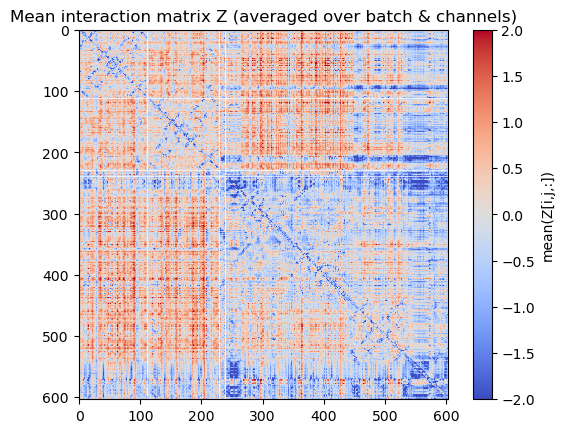

In [7]:
# check the structure of Z matches intuition

for name, sl1, sl2 in [
    ("α-α", s_alpha, s_alpha),
    ("α-β", s_alpha, s_beta),
    ("β-α", s_beta,  s_alpha),
    ("β-β", s_beta,  s_beta),
    ("α-pep", s_alpha, s_pep),
    ("pep-hla", s_pep, s_hla),
    ("hla-α", s_hla, s_alpha),
]:
    print(name, Z[:, sl1, sl2, :].shape)

import matplotlib.pyplot as plt

# collapse batch & channel to a single scalar per (i,j)
Z_mean = Z.mean(dim=(0, 3)).cpu()     # shape (L,L)
Z_norm = (Z_mean - Z_mean.mean()) / Z_mean.std()
plt.imshow(Z_norm.cpu(), cmap='coolwarm', vmin=-2, vmax=2)

plt.colorbar(label='mean(Z[i,j,:])')
plt.title("Mean interaction matrix Z (averaged over batch & channels)")

for b in [112, 229, 239, 604]:
    plt.axhline(b-0.5, color='white', lw=0.5)
    plt.axvline(b-0.5, color='white', lw=0.5)


plt.show()


In [8]:
def block_mean(s1, s2):
    return Z[:, s1, s2, :].abs().mean().item()

print("αα mean:", block_mean(s_alpha, s_alpha))
print("αβ mean:", block_mean(s_alpha, s_beta))
print("ββ mean:", block_mean(s_beta, s_beta))
print("pep-HLA mean:", block_mean(s_pep, s_hla))


αα mean: 16.04496192932129
αβ mean: 15.563531875610352
ββ mean: 16.09992790222168
pep-HLA mean: 13.42902946472168


In [22]:
def max_diff(s1, s2):
    return (Z[:, s1, s2, :] - Z[:, s2, s1, :].transpose(-3,-2)).abs().amax().item()

print("αβ vs βα:", max_diff(s_alpha, s_beta))
print("αpep vs pepα:", max_diff(s_alpha, s_pep))
print("βpep vs pepβ:", max_diff(s_beta, s_pep))
print("pep-HLA vs HLA-pep:", max_diff(s_pep, s_hla))


αβ vs βα: 178.5421142578125
αpep vs pepα: 139.25442504882812
βpep vs pepβ: 131.16519165039062
pep-HLA vs HLA-pep: 229.62942504882812


Part 2: Understanding how symmetrisation and others affects separation between +ves and -ves